In [1]:
import os
import pandas as pd
import random
import plotData
import assembleFeatureMatrix as afm
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.stats import zscore
import scipy.stats as scistats
from sklearn import decomposition

# Step 3: Explore Predictive Modeling

This notebook dives into the process of predictive modeling for Difficulty Level as well as Performance Error. For each of these tasks, we split the development set into training and validation subsets, train a predictive model using the training set, and then assess model performance using the validation set.

### Loading the Development Set Feature Matrix

Start by loading the feature matrix. If you've already run Step 2, you should have the starterCode\data__feats\devSubjsFeatMat.csv file computed so it should load quickly.

In [2]:
#Start by loading the feature matrix as we did in Step 2. 
#If you've already run Step 2, you should have the devSubjsFeatMat.csv file computed so this should load quickly.

dataDirDev = ".." + os.sep + "dataPackage";
featDirDev = "." + os.sep + "data_feats";
modelDirDev = "." + os.sep + "model_eval";

expType = "task-ils"

if (not os.path.exists(featDirDev)):
    os.makedirs(featDirDev);
aggFeatFilePath = featDirDev+os.path.sep+'devSubjsFeatMat.csv'
featMatDF = afm.getFeatureMatrix(dataDirDev+os.path.sep+expType, aggFeatFilePath, True);

if (not os.path.exists(modelDirDev)):
    os.makedirs(modelDirDev);

Found precomputed feature matrix.
Loaded into a dataFrame.


### Split development set into training and validation subjects

In specifying the percentage of subjects to put into the validation set (pctHoldout variable below), feel free to play with the percentages to see what works best. There's a tradeoff to be considered here -- while you want to have enough subjects to validate with to allow for an accurate assessment of the model, more subjects in the training set means more data to train the model better.

In [3]:
pctHoldout = 25; #Percent of subjects to hold out for validation
perfMetricsDF = pd.read_csv(dataDirDev+os.path.sep+
                            expType+os.path.sep+
                            "PerfMetrics.csv");

featMatDF = pd.read_csv(aggFeatFilePath);

mergedDF = plotData.alignFeatPerfRows(featMatDF, perfMetricsDF);
print("mergedDF.cols = "+str(mergedDF.columns));
usubjs = list(set(mergedDF['Subject_x']))
numSubjs = len(usubjs);
numVal = int(numSubjs*float(pctHoldout)/100);
numTrain = numSubjs - numVal;

random.shuffle(usubjs);
trainSet = usubjs[:numTrain];
valSet = usubjs[numTrain:];

trainDF = mergedDF[mergedDF.Subject_x.str.contains('|'.join(trainSet))];
valDF = mergedDF[mergedDF.Subject_x.str.contains('|'.join(valSet))];

#Specifying which of the columns in mergedDF to use for the feature matrix to be input to the predictive models.
featCols = ['overall_gaze_entropy_LX', 'psd_max_LX', 'psd_freq_of_max_LX',
            'overall_gaze_entropy_LY', 'psd_max_LY', 'psd_freq_of_max_LY',
            'overall_gaze_entropy_LZ', 'psd_max_LZ', 'psd_freq_of_max_LZ',
            'overall_gaze_entropy_RX', 'psd_max_RX', 'psd_freq_of_max_RX',
            'overall_gaze_entropy_RY', 'psd_max_RY', 'psd_freq_of_max_RY',
            'overall_gaze_entropy_RZ', 'psd_max_RZ', 'psd_freq_of_max_RZ',
            'eyes_closed_fraction_L', 'eyes_closed_fraction_R',
            'pupil_diam_mean_L', 'pupil_diam_stdev_L', 'pupil_diam_skew_L', 'pupil_diam_kurt_L',
            'pupil_diam_mean_R', 'pupil_diam_stdev_R', 'pupil_diam_skew_R', 'pupil_diam_kurt_R',
            'fix_dur_mean', 'fix_dur_stdev', 'fix_dur_skew', 'fix_dur_kurt',
            'fix_density_mean', 'fix_density_stdev', 'fix_density_skew', 'fix_density_kurt',
            'sac_main_seq_mean', 'sac_main_seq_stdev',
            'sac_peak_vel_mean', 'sac_peak_vel_stdev'];

mergedDF.cols = Index(['Unnamed: 0', 'Subject_x', 'Session_x', 'Run_x',
       'overall_gaze_entropy_LX', 'psd_max_LX', 'psd_freq_of_max_LX',
       'overall_gaze_entropy_LY', 'psd_max_LY', 'psd_freq_of_max_LY',
       'overall_gaze_entropy_LZ', 'psd_max_LZ', 'psd_freq_of_max_LZ',
       'overall_gaze_entropy_RX', 'psd_max_RX', 'psd_freq_of_max_RX',
       'overall_gaze_entropy_RY', 'psd_max_RY', 'psd_freq_of_max_RY',
       'overall_gaze_entropy_RZ', 'psd_max_RZ', 'psd_freq_of_max_RZ',
       'eyes_closed_fraction_L', 'eyes_closed_fraction_R', 'pupil_diam_mean_L',
       'pupil_diam_stdev_L', 'pupil_diam_skew_L', 'pupil_diam_kurt_L',
       'pupil_diam_mean_R', 'pupil_diam_stdev_R', 'pupil_diam_skew_R',
       'pupil_diam_kurt_R', 'fix_dur_mean', 'fix_dur_stdev', 'fix_dur_skew',
       'fix_dur_kurt', 'fix_density_mean', 'fix_density_stdev',
       'fix_density_skew', 'fix_density_kurt', 'sac_main_seq_mean',
       'sac_main_seq_stdev', 'sac_peak_vel_mean', 'sac_peak_vel_stdev',
     

### Train a simple predictive model for difficulty level classification

This simple starter model for Difficulty Level prediction is using a Support Vector Machine classifier. 

In [4]:
def trainDiffPredictionModel(trainMatDF, inclDiffLevels, featCols, numPCs):

    subTrainMatDF = trainMatDF.loc[trainMatDF['difficulty'].isin(inclDiffLevels)];
    
    X = subTrainMatDF[featCols];
    y = subTrainMatDF['difficulty'];
    
    #normalize the feature matrix
    Xz = zscore(X);
    
    #If desired, reduce dimensionality using Principal Components Analysis (PCA)
    pcaSetup = None;
    if (numPCs > 0):
        pcaSetup = decomposition.PCA(n_components=numPCs);
        pcaSetup.fit(Xz);
        Xz = pcaSetup.transform(Xz)
        
    clf = svm.SVC(probability=True);
    clf.fit(Xz, y);

    return [clf, pcaSetup];

In [5]:
inclDiffLevels = [1, 4]; #The task is only to distinguish between difficulty levels 1 and 4.
numPCs = 0;
[clf, pcaSetup_diffLevels] = trainDiffPredictionModel(trainDF, inclDiffLevels, featCols, numPCs); #fitting a simple SVM model to the training data

### Assess difficulty level classification model performance by running it on the validation set

To validate the Difficulty Level classification model, we compute a Receiver Operating Characteristic (ROC) curve that shows the tradeoff between True Positive Rate and False Positive Rate. This is done using the confidence probabilities for each difficulty level that the model assigns to each validation run. The area under this curve (AUC) is metric that is commonly used to quantify predictive model performance with a single number. 

In [6]:
def validateDiffPredictionModel(valMatDF, pcaSetup, inclDiffLevels, featCols, clf, outDir):

    subValMatDF = valMatDF.loc[valMatDF['difficulty'].isin(inclDiffLevels)];

    n_classes = len(inclDiffLevels);
    
    X = subValMatDF[featCols];
    Xz = zscore(X);
    if (pcaSetup is not None):
        Xz = pcaSetup.transform(Xz);
    y_actual = subValMatDF['difficulty'].values;
    y_pred = clf.predict(Xz);
    
    probas = clf.predict_proba(Xz);
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    print("Actual = "+str(y_actual));
    print("Predicted = "+str(y_pred));
    print("Model's Confidence Probabilities = "+str(probas));
    fpr, tpr, _ = roc_curve(y_actual, probas[:,0], pos_label=inclDiffLevels[0]);
    roc_auc = auc(fpr, tpr);

    plt.figure(figsize=(5,5));
    
    plt.plot(fpr, tpr, lw=2);
    
    plt.xlim([-0.05, 1.05]);
    plt.ylim([-0.05, 1.05]);
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Validation Set. AUC = '+str(roc_auc));
    plt.savefig(outDir+os.path.sep+'valDiffLevelROC.png', format='png');
    plt.show();

Actual = [1 1 1 4 4 4 1 1 1 4 4 4 1 1 1 4 4 4 1 1 1 4 4 4 1 1 1 4 4 4 1 1 4 4 4 1 1
 1 4 4 4 1 1 1 4 4 4]
Predicted = [1 4 1 4 1 1 4 4 4 4 4 4 4 1 1 4 4 4 1 1 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1
 1 4 4 1 1 1 1 4 4 1]
Model's Confidence Probabilities = [[0.88650101 0.11349899]
 [0.49338545 0.50661455]
 [0.86728635 0.13271365]
 [0.48951283 0.51048717]
 [0.76951607 0.23048393]
 [0.77737636 0.22262364]
 [0.32159324 0.67840676]
 [0.39683164 0.60316836]
 [0.09196454 0.90803546]
 [0.12316794 0.87683206]
 [0.09726153 0.90273847]
 [0.05560815 0.94439185]
 [0.41667371 0.58332629]
 [0.7151149  0.2848851 ]
 [0.61678595 0.38321405]
 [0.21338874 0.78661126]
 [0.28412142 0.71587858]
 [0.25785982 0.74214018]
 [0.52254347 0.47745653]
 [0.51606166 0.48393834]
 [0.40312902 0.59687098]
 [0.13475554 0.86524446]
 [0.14517253 0.85482747]
 [0.2572805  0.7427195 ]
 [0.08446539 0.91553461]
 [0.16200719 0.83799281]
 [0.45014196 0.54985804]
 [0.28142655 0.71857345]
 [0.11696578 0.88303422]
 [0.38488058 0.61511942]


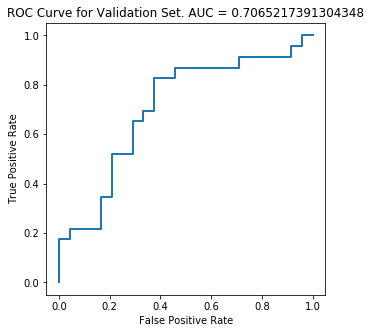

In [7]:
validateDiffPredictionModel(valDF, pcaSetup_diffLevels, inclDiffLevels, featCols, clf, modelDirDev);


### Train a simple predictive model for performance error

For prediction of performance error, here is a starter model using simple Linear Regression. 

In [8]:
def trainPerfErrPredictionModel(trainMatDF, featCols, numPCs):

    subTrainMatDF = trainMatDF;
    
    X = subTrainMatDF[featCols];
    y = subTrainMatDF["cumulative_total_error"];

    Xz = zscore(X);
    
    #If desired, reduce dimensionality using Principal Components Analysis (PCA)
    pcaSetup = None;
    if (numPCs > 0):
        pcaSetup = decomposition.PCA(n_components=numPCs);
        pcaSetup.fit(Xz);
        Xz = pcaSetup.transform(Xz)
        
    mdl = LinearRegression().fit(Xz, y);

    return [mdl, pcaSetup];

In [9]:
numPCs = 2;
[reg, pcaSetup_perfErr] = trainPerfErrPredictionModel(trainDF, featCols, numPCs);

### Assess performance error prediction model by running it on the validation set

Due to the numerical nature of performance error, we assess model performance using Mean Squared Error between predicted and actual. It can also be useful to plot Predicted vs. Actual values for a visual perspective. 

In [10]:
#Performs validation of the trained performance error prediction model by computing mean squared error of predicted vs. actual Cumulative_Error values.
def validatePerfErrPredictionModel(valMatDF, pcaSetup, featCols, mdl, outDir):
    subValMatDF = valMatDF;
    
    X = subValMatDF[featCols];
    Xz = zscore(X);   
    if (pcaSetup is not None):
        Xz = pcaSetup.transform(Xz);
        
    y = subValMatDF['cumulative_total_error'];

    y_pred = mdl.predict(Xz);

    mse = mean_squared_error(y, y_pred);
    pearsonCorr = scistats.pearsonr(y, y_pred);
    [spCorr, spPval] = scistats.spearmanr(y, y_pred);
    
    plt.scatter(y, y_pred);
    lims = [min(min(y), min(y_pred)), max(max(y), max(y_pred))];
    plt.xlim(lims);
    plt.ylim(lims);
    plt.xlabel('Actual');
    plt.ylabel('Predicted');
    plt.title('Total Flight Error: Predicted vs. Actual\n MSE = '+
              str(mse)+"\nPearson Correlation: "+str(pearsonCorr)+
              "\nSpearman Correlation: ("+str(spCorr)+", "+str(spPval)+")");
    plt.savefig(outDir+os.path.sep+'valPerfErr_pred2actual.png', format='png');

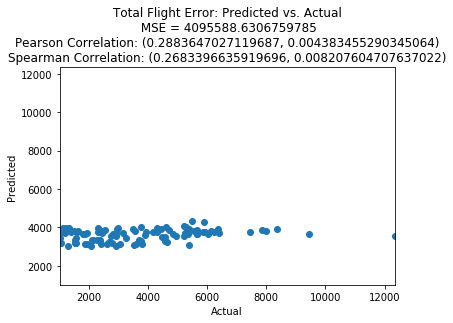

In [11]:
validatePerfErrPredictionModel(valDF, pcaSetup_perfErr, featCols, reg, modelDirDev);

Research was sponsored by the United States Air Force Research Laboratory and the United States Air Force Artificial Intelligence Accelerator and was accomplished under Cooperative Agreement Number FA8750-19-2-1000. The views and conclusions contained in this document are those of the authors and should not be interpreted as representing the official policies, either expressed or implied, of the United States Air Force or the U.S. Government. The U.S. Government is authorized to reproduce and distribute reprints for Government purposes notwithstanding any copyright notation herein.